In [1]:
using LinearAlgebra
using Plots
using Random
using StateSpaceDynamics


const SSD = StateSpaceDynamics

StateSpaceDynamics

In [2]:
# Define parameters
num_trials = 50  # Number of trials
trial_length = 1000  # Number of time steps per trial

# Create the emission models
emission_1 = PoissonRegressionEmission(;
    input_dim=3, output_dim=1, include_intercept=true, β=reshape([4, 3, 2, 4], :, 1)
)
emission_2 = PoissonRegressionEmission(;
    input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 1, 3], :, 1)
)

# Initialize the SwitchingPoissonRegression model
true_model = SwitchingPoissonRegression(; K=2, input_dim=3, output_dim=1)
true_model.A = [0.9 0.1; 0.2 0.8]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Create lists to hold data and labels for each trial
Φ_trials = [randn(3, trial_length) for _ in 1:num_trials]  # Input features for each trial
true_labels_trials = Vector{Vector{Int}}(undef, num_trials)
data_trials = Vector{Matrix{Float64}}(undef, num_trials)

# Sample data for each trial
for i in 1:num_trials
    true_labels_trials[i], data_trials[i] = StateSpaceDynamics.sample(
        true_model, Φ_trials[i]; n=trial_length
    )
end

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(; K=2, input_dim=3, output_dim=1)

# Initialize the emission models for warm start
emission_1 = PoissonRegressionEmission(;
    input_dim=3,
    output_dim=1,
    include_intercept=true,
    β=reshape([2.0, 1.0, 4.0, 2.0], :, 1),
)
emission_2 = PoissonRegressionEmission(;
    input_dim=3,
    output_dim=1,
    include_intercept=true,
    β=reshape([-5.0, -1.0, 0.0, 2.0], :, 1),
)
test_model.B[1], test_model.B[2] = emission_1, emission_2

# Fit the model using data from all trials
ll = StateSpaceDynamics.fit!(test_model, data_trials, Φ_trials; max_iters=200)

Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:27 ( 0.14  s/it)


201-element Vector{Float64}:
    -Inf
     -5.654934404970949e9
 -33999.15366413723
  -3346.440200906839
  -2786.3599795623895
  -2770.6240869684475
  -2768.565210303592
  -2768.210623956553
  -2768.1384405007207
  -2768.122577786561
      ⋮
  -2768.1166215572266
  -2768.116556393976
  -2768.1166099162483
  -2768.11654557724
  -2768.1166003103626
  -2768.116534718456
  -2768.1165869377437
  -2768.116523823451
  -2768.1165773879234

In [15]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=5, include_intercept=true, β=50*rand(3, 5))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=5, include_intercept=true, β=-30*rand(3, 5))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=5, include_intercept=true)
true_model.A = [0.6 0.4; 0.3 0.7]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample trials from the model 100 time points 50 trials or something
num_trials = 100  # Number of times you want to sample


all_labels = Vector{Matrix{Int}}()  # Store each true_labels matrix
all_data = Vector{Matrix{Float64}}()  # Store each data matrix
Φ_total = Vector{Matrix{Float64}}()

for i in 1:num_trials
    n = 10+i
    Φ = randn(2, n)
    true_labels, data = SSD.sample(true_model, Φ, n=n)
    # push!(all_labels, true_labels)
    push!(all_data, data)
    push!(Φ_total, Φ)
end


# # Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=2, output_dim=5, include_intercept=true)
test_model.A = [.1111 0.9999; 0.2222 0.8888]
ll = SSD.fit!(test_model, all_data, Φ_total; max_iters=100)

# # # Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:05 (59.41 ms/it)


truetrue

In [17]:
all_data[1]

5×11 Matrix{Float64}:
 28.6446   5.0866   -13.1608    2.82975   …    4.27332  33.3465    9.60656
 38.5786  11.7918    -9.98333   3.02456      -11.5595   45.9812   -0.227402
 33.6461   6.58835    4.1307   -4.92413      -53.5839   51.801   -28.9969
 17.277   18.6093   -10.6873    0.135058     -52.2142   16.8098  -45.7802
 36.1401   6.7722   -35.3859   -7.21405      -20.3903   48.1742   -2.115

In [3]:
test_model.A

2×2 Matrix{Float64}:
 0.712296  0.287704
 0.388687  0.611313

# Gaussian HMM

In [3]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

output_dim = 2
μ = [0.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_3 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)
#
# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=10000
true_labels, data = SSD.sample(true_model, n=n)

# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
test_model.B[1] = emission_1
test_model.A = [0.8 0.2; 0.05 0.95]
lls = SSD.fit!(test_model, data)

print(isapprox(test_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, true_model.B[2].μ, atol=0.1))
print(isapprox(test_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, true_model.B[1].μ, atol=0.1))

truetrue

In [5]:
SSD.loglikelihood(test_model, data)

UndefVarError: UndefVarError: `emission_loglikelihoods` not defined

In [54]:
test_model.A

2×2 Matrix{Float64}:
 0.901796  0.0982043
 0.810153  0.189847

In [37]:
test_model.B[2].μ

2-element Vector{Float64}:
 1.996792362755173
 0.9899091291424154

In [45]:
lls = [-Inf]
data = (data,)
# transpose data so that correct dimensions are passed to EmissionModels.jl, a bit hacky but works for now.
transpose_data = Matrix.(transpose.(data))

num_obs = size(transpose_data[1], 1)
# initialize forward backward storage
FB_storage = SSD.initialize_forward_backward(test_model, num_obs)

SSD.estep!(test_model, transpose_data, FB_storage)

In [50]:
FB_storage.α

2×10000 Matrix{Float64}:
 -436.323         0.240644   -0.572088  …  -8587.79  -8587.75  -8612.11
   -0.00823141  -26.347     -17.1795       -8609.28  -8618.49  -8590.46

In [48]:
transpose_data[1]

10000×2 Matrix{Float64}:
  2.25584     0.837458
  0.0196819  -0.0816484
  0.361558    0.320145
  1.43208     0.69254
 -0.04613    -0.276725
  0.440059    0.132799
  1.74184     1.72583
  1.97492     0.761777
 -0.255154    0.186409
  0.069949   -0.0889173
  ⋮          
 -0.169008   -0.391008
  0.361558   -0.179718
  2.06916     0.995074
 -0.397545   -0.112927
  1.81584     1.34284
  0.339271   -0.0533657
  0.300483   -0.051962
 -0.240998    0.086352
  2.12374     0.617698

In [4]:
SSD.emission_loglikelihoods!(test_model, FB_storage, transpose_data...)
FB_storage.loglikelihoods

2×10000 Matrix{Float64}:
 -15.8482   -0.205209  -0.159205  …  -0.248589  -3.90579  -24.8337
  -3.46916  -1.90487   -1.90027      -1.90921   -2.27493   -4.36772

In [5]:
SSD.forward!(test_model, FB_storage)
FB_storage.α

2×10000 Matrix{Float64}:
 -18.3935   -6.7518   -6.93775  -7.88035  …  -14167.7  -14171.8  -14196.7
  -3.55086  -5.50702  -7.39972  -9.12288     -14170.5  -14171.3  -14175.6

In [6]:
SSD.backward!(test_model, FB_storage)
FB_storage.β

2×10000 Matrix{Float64}:
 -14169.5  -14169.1  -14168.7  -14167.7  …  -8.44509  -8.15078  -5.97716  0.0
 -14172.0  -14171.6  -14171.1  -14170.2     -8.63799  -6.74307  -4.41901  0.0

In [7]:
SSD.calculate_γ!(test_model, FB_storage)
FB_storage.γ

2×10000 Matrix{Float64}:
 -12.3159      -0.249621  -0.0573202  …  -0.220628  -2.17216  -21.1544
  -4.47991e-6  -1.51003   -2.88763       -1.61956   -0.12096   -6.49379e-10

In [15]:
"""
Find the nearest covariance matrix to matrix A in Frobenius norm using Higham's algorithm.

Arguments:
- `A`: Input matrix (should be square)
- `max_iter`: Maximum number of iterations
- `tol`: Convergence tolerance

Returns:
- The nearest covariance matrix to A
"""
function nearest_covariance_matrix(A; max_iter=100, tol=1e-6)
    # Convert to Matrix{Float64} to ensure numerical stability
    A = convert(Matrix{Float64}, A)
    n = size(A, 1)
    
    # Symmetrize A
    A = (A + A') / 2
    
    # Initial projection onto PSD cone
    F = eigen(Symmetric(A))
    eigvals = max.(F.values, 0)
    X = F.vectors * Diagonal(eigvals) * F.vectors'
    
    # Initialize Dykstra's correction matrices
    Y = zeros(n, n)
    S = zeros(n, n)
    
    for _ in 1:max_iter
        X_old = copy(X)
        
        # Project onto symmetric matrices with unit diagonal
        R = X - Y
        R = (R + R') / 2  # Ensure symmetry
        Y = R - Diagonal(diag(R)) + I
        
        # Project onto PSD cone
        R = Y - S
        F = eigen(Symmetric(R))
        eigvals = max.(F.values, 0)
        X = F.vectors * Diagonal(eigvals) * F.vectors'
        S = X - R
        
        # Check convergence using Frobenius norm
        if norm(X - X_old) < tol
            break
        end
    end
    
    # Ensure perfect symmetry in output
    return (X + X') / 2
end

nearest_covariance_matrix

In [ ]:
"""
Find nearest covariance matrix by simple eigenvalue projection.
Just sets negative eigenvalues to zero.
"""
function enforce_posdef(A)
    # Symmetrize first
    A = (A + A') / 2
    
    # Eigendecomposition and fix negative eigenvalues
    F = eigen(Symmetric(A))
    eigvals = max.(F.values, 0)
    return F.vectors * Diagonal(eigvals) * F.vectors'
end

nearest_covariance_simple

In [33]:
nearest_covariance_matrix([0.98 0.92; 0.92 1.0])

2×2 Matrix{Float64}:
 1.0          1.66533e-16
 1.66533e-16  1.0

In [42]:
nearest_covariance_simple(rand(4, 4))

4×4 Matrix{Float64}:
 0.764114  0.624749  0.628557  0.715401
 0.624749  0.673734  0.345721  0.488553
 0.628557  0.345721  0.828511  0.593067
 0.715401  0.488553  0.593067  0.792134

In [1]:
using LinearAlgebra
# using Plots
using Random
using StateSpaceDynamics


const SSD = StateSpaceDynamics

StateSpaceDynamics

# Section for timing and memory improvements of forward backward

In [10]:
"""
Sample from true model and initialize model to fit
"""

# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 100
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

"""
Time the forward backward algorithm
"""
X=Φ
Y=data
lls = [-Inf]

SSD.fit!(test_model, data, Φ)

# model=test_model
# data = X === nothing ? (Y,) : (X, Y)
# # transpose data so that correct dimensions are passed to EmissionModels.jl, a bit hacky but works for now.
# transpose_data = Matrix.(transpose.(data))
# log_likelihood = -Inf



100


4-element Vector{Float64}:
   -Inf
 -1459.014642217791
  -689.4429633312888
  -689.4429633312888

In [ ]:
num_obs = size(transpose_data[1], 1)
FB_storage = SSD.initialize_forward_backward(model, num_obs)

In [21]:
# Using a local reference
function emission_loglikelihoods!(model::HiddenMarkovModel, FB_storage::SSD.ForwardBackward, data)
    loglikelihoods = FB_storage.loglikelihoods
    for k in 1:model.K
        loglikelihoods[k, :] .= loglikelihood(model.B[k], data...)
    end
end

function emission_loglikelihoods2!(model::HiddenMarkovModel, FB_storage::SSD.ForwardBackward, data)
    for k in 1:model.K
        FB_storage.loglikelihoods[k, :] .= loglikelihood(model.B[k], data...)
    end
end

emission_loglikelihoods2! (generic function with 2 methods)

In [58]:
@time emission_loglikelihoods!(model, FB_storage, transpose_data)
@time emission_loglikelihoods2!(model, FB_storage, transpose_data)

  0.000144 seconds (38 allocations: 314.812 KiB)
  0.000154 seconds (38 allocations: 314.812 KiB)


In [17]:
size(transpose_data[1])[1]

2000

In [3]:
@time γ, ξ, α, β = estep(model, transpose_data);

  1.684387 seconds (2.63 M allocations: 171.443 MiB, 1.31% gc time, 265.26% compilation time)


In [19]:
# compute lls of the observations
println("emission_loglikelihoods stats:")
@time loglikelihoods = SSD.emission_loglikelihoods(model, transpose_data...);

# run forward-backward algorithm
println("forward stats:")
@time α = SSD.forward(model, loglikelihoods);

println("backward stats:")
@time β = SSD.backward(model, loglikelihoods);

println("γ stats:")
@time γ = SSD.calculate_γ(model, α, β)

println("ξ stats:")
@time ξ = SSD.calculate_ξ(model, α, β, loglikelihoods)


emission_loglikelihoods stats:
  0.000186 seconds (113 allocations: 354.211 KiB)
forward stats:
  0.000715 seconds (31.99 k allocations: 531.125 KiB)
backward stats:
  0.000830 seconds (47.98 k allocations: 781.000 KiB)
γ stats:
  0.377217 seconds (273.81 k allocations: 18.531 MiB, 443.97% compilation time)
ξ stats:
  0.124611 seconds (335.17 k allocations: 20.343 MiB, 8.55% gc time, 99.45% compilation time)


2×2×1999 Array{Float64, 3}:
[:, :, 1] =
 -2.50659  -0.937908
 -2.49195  -0.811346

[:, :, 2] =
 -3.564    -1.99532
 -2.03089  -0.350286

[:, :, 3] =
 -3.59334  -2.02467
 -2.02522  -0.344618

;;; … 

[:, :, 1997] =
 -3.59381  -2.02513
 -2.02513  -0.34453

[:, :, 1998] =
 -3.59381  -2.02513
 -2.02513  -0.34453

[:, :, 1999] =
 -3.59381  -2.02513
 -2.02513  -0.34453

# Switching Gaussian Regression #

In [2]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
ll = SSD.fit!(test_model, data, Φ)

# # Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

truetrue

In [5]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[1 2; 1 2; 1 2])
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[2 1; 2 1; 2 1])

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=2, include_intercept=false)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=2, include_intercept=false)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[1.0 2.0; 1.0 2.0; 1.0 2.0])
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=2, include_intercept=false, β=[2.0 1.0; 2.0 1.0; 2.0 1.0])
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=100)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))


truetrue

# Switching Bernoulli Regression #

In [8]:
# Make Emission Models
emission_1 = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([3, 1, 2], :, 1))
emission_2 = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([-3, -2, 0.1], :, 1))

# Create Switching Bernoulli Regression and add the emissions
true_model = StateSpaceDynamics.SwitchingBernoulliRegression(K=2, input_dim=2)
true_model.A = [0.9 0.1; 0.2 0.8]
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n=20000
Φ = randn(2, n)
true_labels, data = StateSpaceDynamics.sample(true_model, Φ, n=n)

# Fit a new Bernoulli Regression Model to the data
test_model = StateSpaceDynamics.SwitchingBernoulliRegression(K=2, input_dim=2, λ=1.0)
test_model.A = [0.75 0.25; 0.1 0.9]
test_model.B[1] = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([2.5, 0.25, 1.0], :, 1))
test_model.B[2] = StateSpaceDynamics.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([-2.0, -3.0, -1.0], :, 1))
ll = StateSpaceDynamics.fit!(test_model, data, Φ, max_iters=200)
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.2) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.2))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.2) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.2))


truefalse

# Switching Poisson Regression

In [10]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([4, 3, 2, 4], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 1, 3], :, 1))

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([2.0, 1.0, 4.0, 2.0], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-5.0, -1.0, 0.0, 2.0], :, 1))
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=200)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))


truetrue

In [1]:
using LinearAlgebra
using Plots
using Random
using StateSpaceDynamics


const SSD = StateSpaceDynamics

StateSpaceDynamics

# Autoregressive HMM

In [57]:
"""
# Construct a gaussian dataset to convert to an autoregressive one for testing
# Create Emission Models
"""
emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([2.0 1.0 ], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([-2.0 -1.0], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=1, include_intercept=false)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 2
Φ = randn(2, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

"""
Construct the AR HMM
"""
# Create autoregressive emission models
AR_emission_1 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.8 -0.6; 0.6 0.8])
AR_emission_2 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.0 -1.0; 1.0 0.0])

# Create the autoregressive model and plug in emission models
true_model = SSD.SwitchingAutoRegression(K=2, output_dim=2, order=1)
true_model.A = [0.8 0.2; 0.2 0.8]
true_model.B[1] = AR_emission_1
true_model.B[2] = AR_emission_2

# Sample from the AR HMM using its own emission models and a starting point
Y = SSD.construct_AR_feature_matrix(data, 1, false)
X = copy(Y[:, end])
X = reshape(Y[:, end], 2, 1)
AR_labels, AR_data = SSD.sample(true_model, X, n=1000, autoregressive=true)


# Define the autoregressive order and dimensions
order = 1
num_samples = size(AR_data, 2)
output_dim = size(AR_data, 1)

# align  Φ (inputs) and Y (outputs) for regression
Φ = AR_data[:, 1:(num_samples - 1)]  # Input: All time steps except the last
Y = AR_data[:, 2:num_samples]        # Output: All time steps except the first

2×999 Matrix{Float64}:
  3.28311  -0.807282  -2.53711   1.56762  …  -46.6786  -70.8786  -64.7358
 -1.17768  -3.88072    0.484858  2.19168     -54.2849  -14.7921   31.0921

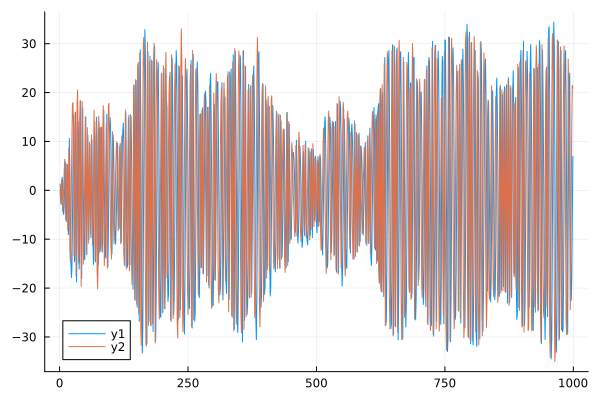

In [50]:
plot(Y')

In [40]:
# Fit a new autoregressive model
# Create autoregressive emission models
AR_emission_1 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[4.0 4.0; 4.0 4.0])
AR_emission_2 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[-0.5 -0.5; -0.5 -0.5])

# Create the autoregressive model and plug in emission models
test_model = SSD.SwitchingAutoRegression(K=2, output_dim=2, order=1)
test_model.B[1] = AR_emission_1
test_model.B[2] = AR_emission_2
test_model.A = [0.6 0.4; 0.3 0.7]

ll = SSD.fit!(test_model, Y, Φ, max_iters=200)

11-element Vector{Float64}:
     -Inf
 -476892.3594830691
  -41380.88490873381
  -37605.84477791658
  -34772.288385163694
  -31328.974192579244
  -25921.12053828879
   -2609.351107631962
   -1310.8193683562604
   -1310.8173926505378
   -1310.8173923876539

# Trialized AR HMM

In [8]:
"""
# Construct a gaussian dataset to convert to an autoregressive one for testing
# Create Emission Models
"""
emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([2.0 1.0 ], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([-2.0 -1.0], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=1, include_intercept=false)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 2
Φ = randn(2, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

"""
Construct the AR HMM
"""
# Create autoregressive emission models
AR_emission_1 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.8 -0.6; 0.6 0.8])
AR_emission_2 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.0 -1.0; 1.0 0.0])

# Create the autoregressive model and plug in emission models
true_model = SSD.SwitchingAutoRegression(K=2, output_dim=2, order=1)
true_model.A = [0.8 0.2; 0.2 0.8]
true_model.B[1] = AR_emission_1
true_model.B[2] = AR_emission_2

# Sample from the AR HMM using its own emission models and a starting point
Y = SSD.construct_AR_feature_matrix(data, 1, false)
X = copy(Y[:, end])
X = reshape(Y[:, end], 2, 1)

num_trials = 100
Φ_session = Vector{Matrix{Float64}}()
Y_session = Vector{Matrix{Float64}}()

for iter=1:num_trials
    AR_labels, AR_data = SSD.sample(true_model, X, n=1000, autoregressive=true)
    # Define the autoregressive order and dimensions
    order = 1
    num_samples = size(AR_data, 2)
    output_dim = size(AR_data, 1)
    # align  Φ (inputs) and Y (outputs) for regression
    Φ = AR_data[:, 1:(num_samples - 1)]  # Input: All time steps except the last
    Y = AR_data[:, 2:num_samples]        # Output: All time steps except the first

    push!(Φ_session, Φ)
    push!(Y_session, Y)
end

# Fit a new autoregressive model
# Create autoregressive emission models
AR_emission_1 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[4.0 4.0; 4.0 4.0])
AR_emission_2 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[-0.5 -0.5; -0.5 -0.5])

# Create the autoregressive model and plug in emission models
test_model = SSD.SwitchingAutoRegression(K=2, output_dim=2, order=1)
test_model.B[1] = AR_emission_1
test_model.B[2] = AR_emission_2
test_model.A = [0.6 0.4; 0.3 0.7]

ll = SSD.fit!(test_model, Y_session, Φ_session, max_iters=500)

Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:25 (50.77 ms/it)


104-element Vector{Float64}:
     -Inf
 -191411.53620324418
  -19123.44140840199
  -17279.375643089254
  -15820.37140749274
  -14426.57766775161
  -13940.167385433564
  -13881.065882932568
  -13893.704040672108
  -13903.622697961191
       ⋮
  -13905.095527163634
  -13905.095532558762
  -13905.095536746569
  -13905.095539997707
  -13905.095542520683
  -13905.095544479585
  -13905.095546000362
  -13905.095547180359
  -13905.09554809652

In [2]:
emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([2.0 1.0 ], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([-2.0 -1.0], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=1, include_intercept=false)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 100
Φ = randn(2, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Sample from the AR HMM using its own emission models and a starting point
order = 1
include_intercept = false
Y = SSD.construct_AR_feature_matrix(data, order, include_intercept)

2×99 Matrix{Float64}:
  2.77134  -3.28196   0.96477  -4.36753  …  1.57186    0.473143  -5.5332
 -3.28196   0.96477  -4.36753  -2.38241     0.473143  -5.5332    -2.02698

In [16]:
data

1×100 Matrix{Float64}:
 -4.50771  -5.10588  -0.864781  …  3.32268  2.80077  2.35111  3.53986

In [4]:
emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([2.0 1.0 ], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([-2.0 -1.0], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=1, include_intercept=false)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2
all_data = Vector{Matrix{Float64}}()  # Store each data matrix
Φ_total = Vector{Matrix{Float64}}()
num_trials = 10
# Sample from the model
for i in 1:num_trials
    Φ = randn(2, 100)
    true_labels, data = SSD.sample(true_model, Φ, n=n)
    push!(all_data, data)
    push!(Φ_total, Φ)
end

# Sample from the AR HMM using its own emission models and a starting point
order = 1
include_intercept = false
Y = SSD.construct_AR_feature_matrix(all_data, order)

[0.2521575947415122 -6.455423841898751 4.204891830336025 -1.97109316056425 0.10217295429970463 2.8921717976879613 -1.45746536184398 2.077356610017925 5.363981739792179 1.182912642407769 -3.8536927103374805 0.43097122374315855 1.16601412676386 -0.6857154805099666 2.8784676646106577 5.71832096190238 0.8903243537952846 -0.7735594529962229 0.3570334555470709 1.1600129429347705 0.8650206144948352 4.02230798922454 0.47346351874288706 2.8250005895050534 2.8814213570187843 2.3237652336737824 0.8937599267440832 3.526528084290085 -2.10901000697088 -1.126554132843144 -0.08366764244886357 -2.3737096131620037 0.2410987784838028 -1.7622024182046578 2.0029432821676023 0.9862503328494951 0.6009995612237118 -0.7748794374061807 2.8805547979517936 0.7432618373658236 -4.854012210542681 4.683425602178222 -1.9178576805373024 -0.6775083716719608 -0.9215123463709818 2.3611773888356513 2.892348866807076 -3.2377959973503736 4.646078002604171 3.9177672553184637 -2.648864462263826 6.232678543016718 -1.05212812971

10-element Vector{Matrix{Float64}}:
 [0.2521575947415122 -6.455423841898751 … -3.2043638725158425 2.4333474987184167; -6.455423841898751 4.204891830336025 … 2.4333474987184167 -0.4907917697860701]
 [-0.02364160444903851 2.054177748891048 … -2.5684575100517275 -1.4691549594778648; 2.054177748891048 -0.7251594175986029 … -1.4691549594778648 1.5949199876267919]
 [3.172968705204265 2.270535339372018 … 0.47172311669384576 -2.7572529392808303; 2.270535339372018 -0.119736998211719 … -2.7572529392808303 -9.619259910977581]
 [2.859429563536639 2.193448443915158 … 1.2717660032285316 -2.249505679484936; 2.193448443915158 -0.26020240630026015 … -2.249505679484936 -1.328440458921653]
 [-1.581521382341465 3.9089354033310526 … -0.11600620309024057 2.0530992013316203; 3.9089354033310526 4.3400273043084425 … 2.0530992013316203 4.146296902590606]
 [-0.6368507926547505 0.8073952345467805 … -0.8952256791557806 -2.635525057027393; 0.8073952345467805 -3.618851170814425 … -2.635525057027393 -1.82426552488063